In [68]:
print('hello world')

hello world


In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('../names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [71]:
len(words)

32033

In [7]:
chars = sorted(set(''.join(words)))
chars = ['.'] + chars  
chars_len = len(chars)
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
print(chars_len, itos)

27 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [8]:
# create dataset
X,Y = [],[]
block_size = 3 

for w in words:
  #print(f'{w=}')
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    #print(f'{''.join(itos[c] for c in context)} -> {itos[ix]}')
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)



In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
embedding_count = 2
C = torch.randn((chars_len,embedding_count))


In [ ]:
C.shape

torch.Size([27, 2])

In [ ]:
C[:5], C[X[1]], X[1]


(tensor([[-0.2461, -1.4353],
         [ 1.0128,  0.7126],
         [-1.5016, -1.3747],
         [ 0.9747, -0.4237],
         [ 1.3302,  1.0201]]),
 tensor([[-0.2461, -1.4353],
         [-0.2461, -1.4353],
         [-0.3878,  0.8029]]),
 tensor([0, 0, 5]))

In [ ]:
C[X].shape

torch.Size([32, 3, 2])

In [ ]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [ ]:
emb[:2, :, :]


tensor([[[-0.2461, -1.4353],
         [-0.2461, -1.4353],
         [-0.2461, -1.4353]],

        [[-0.2461, -1.4353],
         [-0.2461, -1.4353],
         [-0.3878,  0.8029]]])

In [ ]:
#h = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2]) @ W1 + b1
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
h

tensor([[ 0.8798,  0.8795,  0.9258,  ..., -0.9704, -0.9740,  0.8989],
        [ 0.9904,  0.9981, -0.9995,  ..., -0.9989,  0.9962,  0.8465],
        [-0.9962, -0.9743,  0.9078,  ...,  0.5779, -0.7012, -0.9849],
        ...,
        [ 0.8918, -0.4111, -0.7416,  ..., -0.1831, -0.9979, -0.3694],
        [-0.1799,  0.9650, -0.5925,  ...,  0.9869,  1.0000,  0.7976],
        [-0.6474, -0.9753, -0.9993,  ..., -0.8495,  0.9998, -1.0000]])

In [ ]:
h.shape

torch.Size([32, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
F.cross_entropy(logits, Y)

tensor(19.8797)

In [ ]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

p = probs[torch.arange(32), Y]
loss = -p.log().mean()
loss

tensor(19.8797)

In [ ]:
# rewrite to make "respectable" lol

In [18]:
# dataset
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [19]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((chars_len, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, chars_len), generator=g)
b2 = torch.randn(chars_len, generator=g)
parameters = [C, W1, b1, W2, b2]


In [20]:
sum(p.nelement() for p in parameters)

3481

In [21]:
for p in parameters:
  p.requires_grad = True
  

In [22]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [29]:
lri = []
lossi = []
for i in range(1000):
  # minibatches
  ix = torch.randint(0, X.shape[0], (32,), generator=g)

  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())
  # backward pass
  # reset
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lri.append(lre[i])
  lossi.append(loss.item())
  for p in parameters:
    #p.data += -lrs[i] * p.grad
    p.data += -0.01 * p.grad

print(loss.item())
  

2.1807174682617188


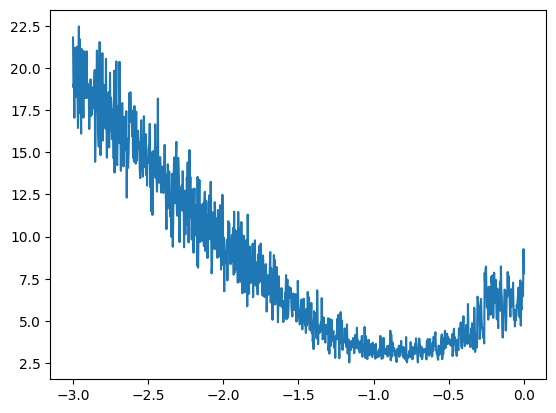

In [24]:
plt.plot(lri, lossi)

In [65]:
# Sampling from logits
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
  out = []
  ix = [0,0,0] # idx zero is '...'
  while True:
    # forward pass
    emb = C[ix]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    hit = torch.multinomial(probs, generator=g, replacement=True, num_samples=1).item()
    ix = ix[1:]+[hit]
    out.append(itos[hit])
    if ix[2] == 0: # idx zero is '.' which means end
      break
  
  print(''.join(out))


dex.
maiealinekilan.
tahnelinimitta.
nrlkadi.
kai.
a.
samitabelansr.
gotas.
moziellnvo.
kerted.
jen.
emia.
sade.
enkaviyny.
fols.
mhinidenvtahlysu.
dsdr.
ban.
jlhgyis.
ihan.
